<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/DEIT_SRGAN_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install torch
!pip install torchvision
import torch

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Normalize, ToTensor
from transformers import AutoFeatureExtractor, ViTForImageClassification

In [5]:
# Load pre-trained DeiT model
model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')

num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [6]:
# Feature extractor for DeiT
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')

# Define image transformations
transform = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Load dataset using ImageFolder
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder("/content/drive/MyDrive/Final_Final/Train", transform=transform)
val_dataset = ImageFolder("/content/drive/MyDrive/Final_Final/Test", transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss function
criterion = CrossEntropyLoss()

In [9]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Header for epoch tracking
print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}{'Val Accuracy':<15}")
print("-" * 50)

for epoch in range(1, 11):  # Number of epochs
    # Training loop
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_dataset)

    # Log epoch results in a tabular format
    tqdm.write(f"{epoch:<8}{train_loss:<15.4f}{val_loss:<15.4f}{val_accuracy:<15.4f}")

    scheduler.step()


Epoch   Train Loss     Val Loss       Val Accuracy   
--------------------------------------------------


1       0.4530         0.2980         0.8941         


2       0.1713         0.2216         0.9121         


3       0.0962         0.3340         0.9044         


4       0.0650         0.3785         0.8992         


5       0.0725         0.2799         0.9225         


6       0.0612         0.2909         0.9018         


7       0.0500         0.3752         0.9018         


8       0.0350         0.3826         0.9018         


9       0.0316         0.2687         0.9096         


10      0.0280         0.3238         0.9096         


In [10]:
model.eval()  # Set the model to evaluation mode
val_loss, correct = 0, 0

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

# Final loss and accuracy
val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Final Validation Pass: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Training Complete!
Final Validation Loss: 0.3305
Final Validation Accuracy: 0.8915


Final Validation Pass: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]



Training Complete!
Final Validation Loss: 0.3514
Final Validation Accuracy: 0.9018


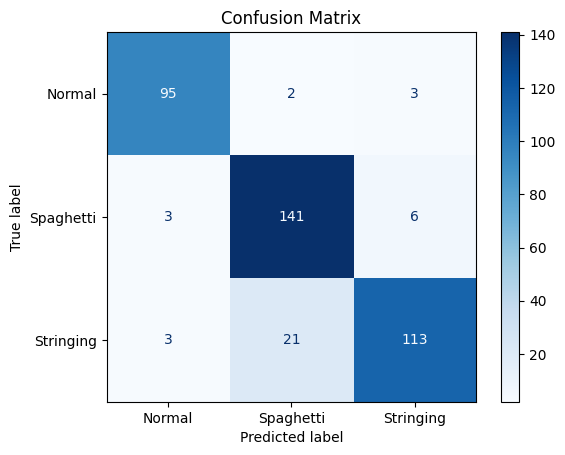

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize variables
val_loss, correct = 0, 0
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Final loss and accuracy
val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()
